# 14. RNN을 이용한 인코더-디코더

## 3) BLEU Score(Bilingual Evaluation Understudy Score)

기계 번역의 성능이 얼마나 뛰어난가를 측정하기 위해 사용되는 대표적인 방법인 BLEU(Bilingual Evaluation Understudy) 대해서 학습해보겠습니다. 

In [1]:
import numpy as np
from collections import Counter
from nltk import ngrams

### 1. BLEU(Bilingual Evaluation Understudy)

#### 1) 단어 개수 카운트로 측정하기(Unigram Precision)

Example 1
+ Candidate1 : It is a guide to action which ensures that the military always obeys the commands of the party.

+ Candidate2 : It is to insure the troops forever hearing the activity guidebook that party direct.

+ Reference1 : It is a guide to action that ensures that the military will forever heed Party commands.

+ Reference2 : It is the guiding principle which guarantees the military forces always being under the command of the Party.

+ Reference3 : It is the practical guide for the army always to heed the directions of the party.

$ \text{유니그램 정밀도} = {\text{Ref들 중에서 존재하는 Ca의 단어 수} \over \text{Ca의 총 단어 수}} $

#### 2) 중복을 제거하여 보정하기(Modified Unigram Precision)

Example 2
+ Candidate : the the the the the the the

+ Reference1 : the cat is on the mat

+ Reference2 : there is a cat on the mat

$ Count_{clip} = \text{min(Count, Max_Ref_Count)} $

$ \text{보정된 유니그램 정밀도} = {\text{Ca의 각 유니그램에 대해 } Count _{clip}{\text을 수행한 값} \over \text{Ca의 총 유니그램 수}} $

#### 3) 보정된 유니그램 정밀도 (Modified Unigram Precision) 구현하기

우선 유니그램을 단순히 Count하는 함수를 simple_count라는 이름의 아래 함수로 구현합니다.

In [2]:
# 토큰화 된 문장(tokens)에서 n-gram을 카운트
def simple_count(tokens, n):
    return Counter(ngrams(tokens, n))

Example 1의 Ca1를 가져와 함수가 어떤 결과를 출력하는지 확인해봅시다.

In [4]:
candidate = "It is a guide to action which ensures that the military always obeys the commands of the party."
tokens = candidate.split() # 토큰화
result = simple_count(tokens, 1) # n = 1은 유니그램
print('유니그램 카운트 :\n', result)

유니그램 카운트 :
 Counter({('the',): 3, ('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('which',): 1, ('ensures',): 1, ('that',): 1, ('military',): 1, ('always',): 1, ('obeys',): 1, ('commands',): 1, ('of',): 1, ('party.',): 1})


이번에는 Example 2의 Ca를 가지고 함수를 수행해봅시다.

In [5]:
candidate = 'the the the the the the the'
tokens = candidate.split() # 토큰화
result = simple_count(tokens, 1) # n = 1은 유니그램
print('유니그램 카운트 :', result)

유니그램 카운트 : Counter({('the',): 7})


이번에는 Count<sub>clip</sub> 을 아래의 count_clip 이름을 가진 함수로 구현해보겠습니다.

In [6]:
def count_clip(candidate, reference_list, n):
    # Ca 문장에서 n-gram 카운트
    ca_cnt = simple_count(candidate, n)
    max_ref_cnt_dict = dict()

    for ref in reference_list: 
        # Ref 문장에서 n-gram 카운트
        ref_cnt = simple_count(ref, n)

        # 각 Ref 문장에 대해서 비교하여 n-gram의 최대 등장 횟수를 계산.
        for n_gram in ref_cnt: 
            if n_gram in max_ref_cnt_dict:
                max_ref_cnt_dict[n_gram] = max(ref_cnt[n_gram], max_ref_cnt_dict[n_gram])
            else:
                max_ref_cnt_dict[n_gram] = ref_cnt[n_gram]

    return {
        # count_clip = min(count, max_ref_count)
        n_gram: min(ca_cnt.get(n_gram, 0), max_ref_cnt_dict.get(n_gram, 0)) for n_gram in ca_cnt
     }

Example 2를 통해 함수가 정상 작동되는지 확인해봅시다.

In [7]:
candidate = 'the the the the the the the'
references = [
    'the cat is on the mat',
    'there is a cat on the mat'
]
result = count_clip(candidate.split(), list(map(lambda ref: ref.split(), references)),1)
print('보정된 유니그램 카운트 :', result)

보정된 유니그램 카운트 : {('the',): 2}


위의 두 함수를 사용하여 예제 문장에 대해서 보정된 정밀도를 연산하는 함수를 **modified_precision**란 이름의 함수로 구현해봅시다.

In [8]:
def modified_precision(candidate, reference_list, n):
    clip_cnt = count_clip(candidate, reference_list, n) 
    total_clip_cnt = sum(clip_cnt.values()) # 분자

    cnt = simple_count(candidate, n)
    total_cnt = sum(cnt.values()) # 분모

    # 분모가 0이 되는 것을 방지
    if total_cnt == 0: 
        total_cnt = 1

    # 분자 : count_clip의 합, 분모 : 단순 count의 합 ==> 보정된 정밀도
    return (total_clip_cnt / total_cnt)

In [9]:
result = modified_precision(candidate.split(), list(map(lambda ref: ref.split(), references)), n=1)
print('보정된 유니그램 정밀도 :', result)

보정된 유니그램 정밀도 : 0.2857142857142857


#### 4) 순서를 고려하기 위해서 n-gram으로 확장하기

BoW 표현과 유사하게, 유니그램 정밀도와 같이 각 단어의 빈도수로 접근하는 방법은 결국 단어의 순서를 고려하지 않는다는 특징이 있습니다. 

Example 1

+ Candidate3 : the that military a is It guide ensures which to commands the of action obeys always party the.

Ca3은 사실 Ca1에서 모든 유니그램의 순서를 랜덤으로 섞은 실제 영어 문법에 맞지 않은 문장입니다. 

하지만 Ref 1, 2, 3과 비교하여 유니그램 정밀도를 적용하면 Ca1과 Ca3의 두 정밀도는 동일합니다. 유니그램 정밀도는 유니그램의 순서를 전혀 고려하지 않기 때문입니다. 

Example 2

+ Candidate2 : the cat the cat on the mat

이해를 돕고자 **Example 2**에 Ca2를 새로 추가했습니다. Ca2 바이그램의 Count와 
Count<sub>clip</sub>은 아래와 같습니다.


|바이그램|the cat|cat the|cat on|on the|the mat|SUM|
|-|-|-|-|-|-|-|
|Count|2|1|1|1|1|6|
|Count<sub>clip</sub>|1|0|1|1|1|4|

보정된 유니그램 정밀도는 다음과 같습니다.

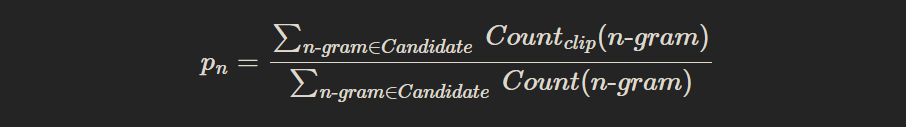

#### 5) 짧은 문장 길이에 대한 패널티(Brevity Penalty)

Ca가 Ref보다 문장의 길이가 짧은 경우에는 점수에 패널티를 줄 필요가 있습니다. 이를 **브레버티 패널티(Brevity Penalty)**라고 합니다.

브레버티 패널티는 앞서 배운 BLEU의 식에 곱하는 방식으로 사용합니다. 브레버티 패널티를 줄여서 BP라고 하였을 때, 최종 BLEU의 식은 아래와 같습니다.

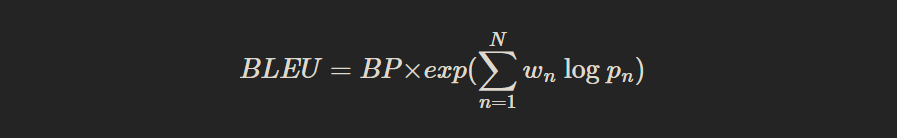

위의 수식은 패널티를 줄 필요가 없는 경우에는 BP의 값이 1이어야 함을 의미합니다. 이를 반영한 BP의 수식은 아래와 같습니다.

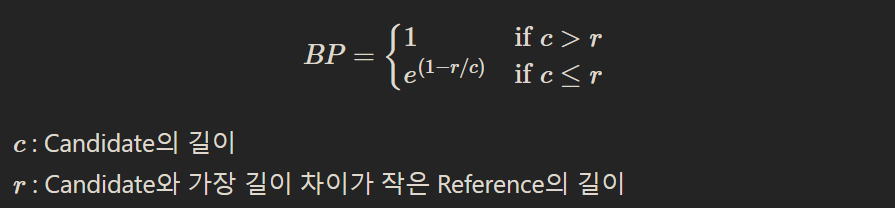

여기서는 Ref가 여러 개일 때를 가정하고 있으므로 r은 모든 Ref들 중에서 Ca와 가장 길이 차이가 작은 Ref의 길이로 합니다.

r을 구하는 코드는 아래와 같습니다.

In [10]:
# Ca 길이와 가장 근접한 Ref의 길이를 리턴하는 함수
def closest_ref_length(candidate, reference_list):
    ca_len = len(candidate) # ca 길이
    ref_lens = (len(ref) for ref in reference_list) # Ref들의 길이
    # 길이 차이를 최소화하는 Ref를 찾아서 Ref의 길이를 리턴
    closest_ref_len = min(ref_lens, key=lambda ref_len: (abs(ref_len - ca_len), ref_len))
    return closest_ref_len

closest_ref_length 함수를 통해 r을 구했다면, BP를 구하는 함수 brevity_penalty를 구현해봅시다.

위 함수는 앞서 배운 BP의 수식처럼 c가 r보다 클 경우에는 1을 리턴하고, 그 외의 경우에는 e<sup>1−r/c</sup>를 리턴합니다.

In [11]:
def brevity_penalty(candidate, reference_list):
    ca_len = len(candidate)
    ref_len = closest_ref_length(candidate, reference_list)

    if ca_len > ref_len:
        return 1

    # candidate가 비어있다면 BP = 0 → BLEU = 0.0
    elif ca_len == 0 :
        return 0
    else:
        return np.exp(1 - ref_len/ca_len)

최종적으로 BLEU 점수를 계산하는 함수 bleu_score를 구현해봅시다.

In [12]:
def bleu_score(candidate, reference_list, weights=[0.25, 0.25, 0.25, 0.25]):
    bp = brevity_penalty(candidate, reference_list) # 브레버티 패널티, BP

    p_n = [modified_precision(candidate, reference_list, n=n) for n, _ in enumerate(weights,start=1)] 
    # p1, p2, p3, ..., pn
    score = np.sum([w_i * np.log(p_i) if p_i != 0 else 0 for w_i, p_i in zip(weights, p_n)])
    return bp * np.exp(score)

### 2. NLTK를 사용한 BLEU 측정하기

파이썬에서는 NLTK 패키지를 사용하여 BLEU를 계산할 수 있습니다.

In [13]:
import nltk.translate.bleu_score as bleu

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

print('실습 코드의 BLEU :',bleu_score(candidate.split(),list(map(lambda ref: ref.split(), references))))
print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))

실습 코드의 BLEU : 0.5045666840058485
패키지 NLTK의 BLEU : 0.5045666840058485
